## Persisting Memory with a Database in LangGraph

### Overview

This demo explains how to **persist memory** across sessions by saving conversation history into a **SQLite database** instead of keeping it only in RAM. This makes it possible to **resume conversations** later and builds the foundation for session-based systems.

In [27]:
import sqlite3
import json
from langchain_core.messages import HumanMessage

from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

True

### 1. **Helper Function for Running Graphs**

- A `run_graph` helper function is created to simplify invoking the graph repeatedly:
    - Takes a query, the graph object, and a `thread_id`.

In [28]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [29]:
def run_graph(query:str, graph:StateGraph, thread_id:int):
    output = graph.invoke(
        config={"configurable":{"thread_id": thread_id}},
        input={"messages":[HumanMessage(query)]}
    )
    return output

### 2. **SQLite-Persisted Workflow Setup**

#### a. **SqliteSaver Checkpointer**

- A **SqliteSaver** is used to persist workflow state to a SQLite database file (`memory.db`).

In [30]:
def chatbot(state: MessagesState):
    ai_message = llm.invoke(state["messages"])
    return {"messages": ai_message}


workflow = StateGraph(MessagesState)

workflow.add_node(chatbot)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

In [31]:
# For production, use something like Postgres
db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

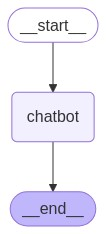

In [32]:
memory = SqliteSaver(conn)
external_memory_graph = workflow.compile(checkpointer=memory)

display(
    Image(
        external_memory_graph.get_graph().draw_mermaid_png()
    )
)

#### b. **Execution**

- The same queries are sent, but this time, metadata and snapshots are saved into the SQLite database.

In [33]:
run_graph(
    query="What's a memory?",
    graph=external_memory_graph, 
    thread_id="2"
)

{'messages': [HumanMessage(content="What's a memory?", id='02da0acd-28ec-457e-9b15-a473f3eb409c'),
  AIMessage(content='Memory refers to the cognitive process by which information is encoded, stored, and retrieved in the brain. It encompasses various types of information, including experiences, knowledge, skills, and facts. Memory can be categorized into different types:\n\n1. **Sensory Memory**: The brief retention of sensory information (e.g., sights, sounds) for a very short period, typically less than a second.\n\n2. **Short-Term Memory**: Also known as working memory, this type holds a limited amount of information for a short duration, usually around 20 to 30 seconds. It allows for the manipulation and processing of information.\n\n3. **Long-Term Memory**: This type can store vast amounts of information for extended periods, ranging from days to a lifetime. Long-term memory is further divided into:\n   - **Explicit (Declarative) Memory**: Involves conscious recall of facts and ev

In [34]:
list(
    external_memory_graph.get_state(
        config={"configurable":{"thread_id": "2"}}
    )
)

[{'messages': [HumanMessage(content="What's a memory?", id='02da0acd-28ec-457e-9b15-a473f3eb409c'),
   AIMessage(content='Memory refers to the cognitive process by which information is encoded, stored, and retrieved in the brain. It encompasses various types of information, including experiences, knowledge, skills, and facts. Memory can be categorized into different types:\n\n1. **Sensory Memory**: The brief retention of sensory information (e.g., sights, sounds) for a very short period, typically less than a second.\n\n2. **Short-Term Memory**: Also known as working memory, this type holds a limited amount of information for a short duration, usually around 20 to 30 seconds. It allows for the manipulation and processing of information.\n\n3. **Long-Term Memory**: This type can store vast amounts of information for extended periods, ranging from days to a lifetime. Long-term memory is further divided into:\n   - **Explicit (Declarative) Memory**: Involves conscious recall of facts and 

### 3. **Inspecting the SQLite Database**

#### a. **Schema Inspection**

- A cursor is created to query the database.
- Two tables are found:
    - `checkpoints`
    - `writes`

In [35]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [table_name[0] for table_name in cursor.fetchall()]
tables

['checkpoints', 'writes']

In [36]:
columns_map = []
results = []

for table in tables:
    cursor.execute(f"select * from {table}")
    results.append(cursor.fetchall())
    columns_map.append({table:[desc[0] for desc in cursor.description]})

In [37]:
columns_map

[{'checkpoints': ['thread_id',
   'checkpoint_ns',
   'checkpoint_id',
   'parent_checkpoint_id',
   'type',
   'checkpoint',
   'metadata']},
 {'writes': ['thread_id',
   'checkpoint_ns',
   'checkpoint_id',
   'task_id',
   'idx',
   'channel',
   'type',
   'value']}]

#### b. **Metadata Retrieval**

- Metadata columns contain serialized snapshots of:
    - Node transitions
    - Message exchanges (e.g., HumanMessage, AIMessage)
    - Model configurations

In [39]:
cursor.execute(f"select metadata from checkpoints")
metadata = cursor.fetchall()
metadata

[(b'{"source": "input", "writes": {"__start__": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "What\'s a memory?", "type": "human"}}]}}, "step": -1, "parents": {}}',),
 (b'{"source": "loop", "writes": null, "step": 0, "parents": {}}',),
 (b'{"source": "loop", "writes": {"chatbot": {"messages": {"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "AIMessage"], "kwargs": {"content": "Memory refers to the cognitive process by which information is encoded, stored, and retrieved in the brain. It encompasses various types of information, including experiences, knowledge, skills, and facts. Memory can be categorized into different types:\\n\\n1. **Sensory Memory**: The brief retention of sensory information (e.g., sights, sounds) for a very short period, typically less than a second.\\n\\n2. **Short-Term Memory**: Also known as working memory, this type holds a limited amount of information

Example metadata entries:

- Step -1: HumanMessage ("What is memory?")
- Step 0: System setup
- Step 1: AIMessage ("Memory can refer to several concepts...")

In [40]:
steps = [json.loads(m[0]) for m in metadata]
steps

[{'source': 'input',
  'writes': {'__start__': {'messages': [{'lc': 1,
      'type': 'constructor',
      'id': ['langchain', 'schema', 'messages', 'HumanMessage'],
      'kwargs': {'content': "What's a memory?", 'type': 'human'}}]}},
  'step': -1,
  'parents': {}},
 {'source': 'loop', 'writes': None, 'step': 0, 'parents': {}},
 {'source': 'loop',
  'writes': {'chatbot': {'messages': {'lc': 1,
     'type': 'constructor',
     'id': ['langchain', 'schema', 'messages', 'AIMessage'],
     'kwargs': {'content': 'Memory refers to the cognitive process by which information is encoded, stored, and retrieved in the brain. It encompasses various types of information, including experiences, knowledge, skills, and facts. Memory can be categorized into different types:\n\n1. **Sensory Memory**: The brief retention of sensory information (e.g., sights, sounds) for a very short period, typically less than a second.\n\n2. **Short-Term Memory**: Also known as working memory, this type holds a limited 

### 4. **Conclusion**

- Persisting memory with a database turns ephemeral conversations into durable sessions.
- LangGraph's checkpoint system allows flexible storage backends.
- This pattern is crucial for production-grade chatbot and agent applications that require history continuity across sessions.